## Cargamos las librerías

In [2]:
import numpy as np  # Importa la biblioteca NumPy para trabajar con arreglos y operaciones matemáticas.
import matplotlib.pyplot as plt  # Importa Matplotlib para crear gráficos y visualizaciones.
import pandas as pd  # Importa Pandas para manipulación y análisis de datos en estructuras tipo DataFrame.
import numpy as np  # (Repetido) Vuelve a importar NumPy, aunque ya se había importado antes.
import seaborn as sns  # Importa Seaborn para visualizaciones estadísticas más atractivas y detalladas.
from sklearn.preprocessing import StandardScaler  # Importa StandardScaler para normalizar los datos.
from sklearn.model_selection import train_test_split  # Importa la función para dividir los datos en entrenamiento y prueba.
from sklearn.neighbors import KNeighborsClassifier  # Importa el clasificador K-Nearest Neighbors (KNN).
from sklearn.metrics import accuracy_score  # Importa la métrica para evaluar la precisión del modelo.

<div id="about_dataset">
    <h2>Sobre el dataset</h2>
</div>


Imagina que un proveedor de telecomunicaciones ha segmentado sus clientes según sus patrones de uso del servicio, categorizando a los clientes en cuatro grupos.

Si los datos demográficos pueden utilizarse para predecir a qué grupo pertenece un cliente, la empresa podrá personalizar las ofertas para cada cliente potencial.

Se trata de un problema de clasificación. Es decir, dado un conjunto de datos con etiquetas predefinidas, necesitamos construir un modelo que pueda predecir la clase de un caso nuevo o desconocido.

Este ejemplo se centra en el uso de datos demográficos, como región, edad y estado civil, para predecir los patrones de uso.

El campo objetivo, llamado custcat, tiene cuatro posibles categorías de servicio que corresponden a los cuatro grupos de clientes:

1. Servicio básico
2. Servicio electrónico
3. Servicio plus
4. Servicio total

Nuestro objetivo es construir un clasificador que pueda predecir la categoría de servicio para casos desconocidos. Utilizaremos un tipo específico de clasificación llamado K vecinos más cercanos (K-nearest neighbors).


### Cargamos los datos


Vamos a leer el csv con pandas. Luego imprimimos las 5 primeras filas.

In [3]:
# Carga el conjunto de datos desde una URL directamente en un DataFrame de Pandas.
# El archivo CSV contiene información demográfica y de uso de servicios de clientes de telecomunicaciones.
df = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/teleCust1000t.csv')
# Muestra las primeras cinco filas del DataFrame para obtener una vista preliminar de los datos
df.head()

,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside,custcat
0,2,13,44,1,9,64.0,4,5,0.0,0,2,1
1,3,11,33,1,7,136.0,5,5,0.0,0,6,4
2,3,68,52,1,24,116.0,1,29,0.0,1,2,3
3,2,33,33,0,12,33.0,2,0,0.0,1,1,1
4,2,23,30,1,9,30.0,1,2,0.0,0,4,3


<div id="visualization_analysis">
    <h2>Visualización de datos y análisis</h2>
</div>


Primero, veamos la distribución de clases en el conjunto de datos.

In [4]:
# Cuenta cuántas veces aparece cada categoría en la columna 'custcat'.
# Esto permite ver la distribución de los clientes según su tipo de servicio: 1- Básico, 2- Electrónico, 3- Plus y 4- Total.

df['custcat'].value_counts()

,count
custcat,
3,281
1,266
4,236
2,217


Por lo tanto, podemos decir que tenemos registros de 281 clientes que optan por el Servicio Plus, 266 por el Servicio Básico, 236 por el Servicio Total y 217 por el Servicio Electrónico. Así, se puede observar que el conjunto de datos está mayormente equilibrado entre las diferentes clases y no requiere métodos especiales para corregir sesgos de clase.

<div id="visualization_analysis">
    <h3>Mapa de calor</h3>
</div>

También podemos visualizar el mapa de correlación del conjunto de datos para determinar cómo se relacionan entre sí las diferentes características.

Una matriz de correlación muestra cómo se relacionan las variables numéricas de un conjunto de datos. Cada celda de la matriz contiene un valor entre -1 y 1 que indica el grado de correlación:

* 1: correlación positiva perfecta (cuando una variable aumenta, la otra también).
* 0: sin correlación (no hay relación lineal).
* -1: correlación negativa perfecta (cuando una variable aumenta, la otra disminuye).

Un mapa de calor (heatmap) es una representación visual de esa matriz, donde los colores indican la intensidad y el tipo de correlación:
* Colores rojos o cálidos suelen representar correlaciones positivas.
* Colores azules o fríos suelen representar correlaciones negativas.
* Colores más neutros indican poca o ninguna correlación.

Además, se pueden incluir los valores numéricos dentro de cada celda para facilitar la interpretación.

Este tipo de visualización es muy útil para:

* Detectar variables redundantes (muy correlacionadas entre sí).
* Identificar relaciones interesantes entre características.
* Tomar decisiones sobre qué variables incluir o excluir en un modelo de machine learning.

<Axes: >

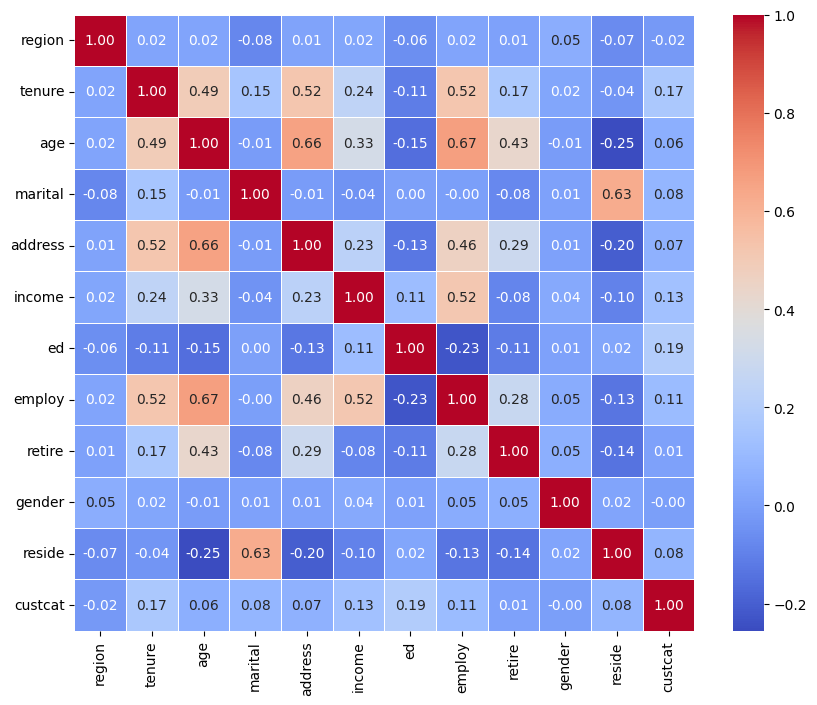

In [5]:
# Calcula la matriz de correlación entre todas las variables numéricas del DataFrame.
# Esto permite identificar relaciones lineales entre las distintas características.

correlation_matrix = df.corr()

# Crea una figura de tamaño 10x8 pulgadas para que el gráfico sea más legible.
plt.figure(figsize=(10, 8))


# Genera un mapa de calor (heatmap) usando Seaborn para visualizar la matriz de correlación.
# - annot=True: muestra los valores numéricos dentro de cada celda.
# - cmap='coolwarm': usa una paleta de colores que va del azul (correlación negativa) al rojo (correlación positiva).
# - fmt='.2f': muestra los valores con dos decimales.
# - linewidths=0.5: agrega líneas divisorias entre las celdas para mejorar la visualización.

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

Como se puede observar en el mapa de correlación, algunas características presentan una mejor correlación entre ellas que otras, lo que indica básicamente la profundidad de la relación entre dos variables. Lo que nos interesa es la correlación de la variable objetivo, es decir, custcat, con todas las demás características. Esto nos ayudará a identificar qué variables deben recibir mayor atención en el modelado y cuáles pueden ser ignoradas.

El siguiente fragmento de código nos proporcionará una lista de características ordenadas en orden descendente según el valor absoluto de su correlación con respecto al campo objetivo (El valor absoluto es el mismo número pero sin tener en cuenta el signo. Hacemos esto puesto que hay más correlación cuanto más se acerca tanto a 1 como a -1)

In [6]:
# Calcula la correlación de todas las variables numéricas con respecto a la variable objetivo 'custcat'.
# - df.corr(): genera la matriz de correlación del DataFrame.
# - ['custcat']: selecciona solo la columna de correlaciones de 'custcat'.
# - drop('custcat'): elimina la autocorrelación (que siempre es 1) para no incluirla en el análisis.
# - abs(...): toma el valor absoluto de las correlaciones para considerar tanto correlaciones positivas como negativas.
# - sort_values(ascending=False): ordena las correlaciones de mayor a menor.

correlation_values = abs(df.corr()['custcat'].drop('custcat')).sort_values(ascending=False)

# Muestra la lista de características ordenadas según su correlación absoluta con 'custcat'.
# Esto ayuda a identificar qué variables tienen mayor relación con la variable objetivo y podrían ser más útiles para el modelo
correlation_values

,custcat
ed,0.193864
tenure,0.166691
income,0.134525
employ,0.110011
marital,0.083836
reside,0.082022
address,0.067913
age,0.056909
region,0.023771
retire,0.008908


Esto nos muestra que las características `retire` y `gender` tienen el menor efecto sobre `custcat`, mientras que `ed` y `tenure` tienen el mayor efecto.


### Separar las características de entrada y la variable objetivo.


Ahora podemos separar los datos en el conjunto de características de entrada y el conjunto de la variable objetivo.

In [7]:
# Crea el conjunto de características de entrada (X) eliminando la columna 'custcat' del DataFrame.
# 'custcat' es la variable objetivo, por lo que no debe incluirse entre las variables predictoras.
X = df.drop('custcat',axis=1)

# Asigna la columna 'custcat' al conjunto de salida (y), que representa las etiquetas o clases que queremos predecir.
y = df['custcat']

## Normaliza los datos


La normalización de datos es importante para el modelo KNN.

KNN realiza predicciones basándose en la distancia entre puntos de datos (muestras), es decir, para un punto de prueba dado, el algoritmo encuentra los k vecinos más cercanos midiendo la distancia entre ese punto y los demás puntos del conjunto de datos. Al normalizar o estandarizar los datos, se garantiza que todas las características contribuyan por igual al cálculo de la distancia. Dado que la normalización escala cada característica para que tenga media cero y varianza unitaria, todas las variables quedan en la misma escala (sin que ninguna domine por tener un rango más amplio).

Esto ayuda a que KNN tome mejores decisiones basadas en las relaciones reales entre las características, y no simplemente en la magnitud de sus valores.


In [8]:
# Aplica la normalización (estandarización) a las características de entrada X.
# - StandardScaler(): crea un objeto que normaliza los datos para que cada característica tenga media 0 y desviación estándar 1.
# - fit_transform(X): ajusta el escalador a los datos y transforma X en su versión normalizada.
# El resultado se guarda en X_norm, que contiene las mismas variables pero en una escala uniforme.

X_norm = StandardScaler().fit_transform(X)

### División en entrenamiento y test

Ahora separamos los datos de entrenamiento y de prueba. Puedes reservar el 20% de los datos para fines de prueba y utilizar el resto para entrenamiento. Asignar un estado aleatorio garantiza la reproducibilidad de los resultados en múltiples ejecuciones.


In [9]:
# Divide los datos en conjuntos de entrenamiento y prueba.
# - X_norm: conjunto de características normalizadas.
# - y: variable objetivo (categoría de servicio).
# - test_size=0.2: reserva el 20% de los datos para el conjunto de prueba.
# - random_state=4: fija una semilla aleatoria para asegurar que la división sea reproducible en futuras ejecuciones.
# El resultado son cuatro subconjuntos: características y etiquetas para entrenamiento (X_train, y_train) y para prueba (X_test, y_test).

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=4)

## Clasificación KNN


Ahora podemos entrenar el modelo

### Entrenamiento
Inicialmente, probemos a empezar un valor bajo de k, por ejemplo k=3

In [10]:
# Define el número de vecinos más cercanos (k) que se utilizarán en el modelo KNN.
# En este caso, se seleccionan los 3 vecinos más cercanos para tomar decisiones de clasificación.
k = 3

# Entrenar el modelo y hacer predicciones, el clasificador se guarda en knn_classifier
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# Ajusta (entrena) el modelo KNN utilizando los datos de entrenamiento.
# El modelo aprende a clasificar los datos en función de las distancias entre puntos.
knn_model = knn_classifier.fit(X_train,y_train)

### Predicciones
Una vez hemos entrenado el modelo, vamos a generar predicciones para el test

In [11]:
# Utiliza el modelo KNN entrenado para hacer predicciones sobre el conjunto de prueba.
# - X_test: contiene las características de los datos que el modelo no ha visto durante el entrenamiento.
# - predict(): genera las predicciones de clase para cada muestra en X_test.
# El resultado, yhat, es un array con las categorías de servicio predichas para los clientes del conjunto de prueba.

yhat = knn_model.predict(X_test)

### Evaluación de la precisión

En la clasificación multietiqueta, la "Accuracy classification score" (puntuación de precisión de clasificación) es una función que calcula la precisión por subconjunto. Esta función es equivalente a la función jaccard_score. Básicamente, calcula lo bien que coinciden las etiquetas reales y las etiquetas predichas en el conjunto de prueba.


In [12]:
# Calcula y muestra la precisión del modelo en el conjunto de prueba.
# - accuracy_score(y_test, yhat): compara las etiquetas reales (y_test) con las etiquetas predichas (yhat).
# La precisión indica el porcentaje de predicciones correctas realizadas por el modelo.
# Este valor nos da una idea de lo bien que está funcionando el modelo KNN con datos no vistos.

print("Test set Accuracy: ", accuracy_score(y_test, yhat))

Test set Accuracy:  0.315


### Vamos a construir el modelo de nuevo, pero con k= 6


In [13]:

# Define el número de vecinos más cercanos (k) que se utilizarán en el modelo KNN.
# En este caso, se seleccionan los 6 vecinos más cercanos para tomar decisiones de clasificación.
k = 6
# Entrenar el modelo y hacer predicciones. Crea el clasificador knn_classifier6
knn_classifier6 = KNeighborsClassifier(n_neighbors=k)

# Ajusta (entrena) el modelo KNN utilizando los datos de entrenamiento.
knn_model6 = knn_classifier6.fit(X_train,y_train)

# Realiza predicciones sobre el conjunto de prueba usando el modelo entrenado.
yhat6 = knn_model6.predict(X_test)


# Calcula y muestra la precisión del modelo en el conjunto de prueba.
# Compara las etiquetas reales (y_test) con las predichas (yhat6) y muestra el porcentaje de aciertos.
print("Test set Accuracy: ", accuracy_score(y_test, yhat6))

Test set Accuracy:  0.31


### Elegir el valor correcto de k

En KNN, k es el número de vecinos más cercanos que se examinan. Sin embargo, la elección del valor de `k` afecta claramente al modelo. Por lo tanto, seleccionar adecuadamente el valor de la variable `k` se convierte en una tarea importante. La forma habitual de hacerlo es entrenar el modelo con diferentes valores de k y observar el rendimiento del modelo entrenado en el conjunto de prueba. El modelo con el mejor valor de `accuracy_score` será el que tenga el valor ideal del parámetro `k`.

Verifica el rendimiento del modelo para 10 valores de `k`, en el rango de 1 a 9. Puedes evaluar la precisión junto con la desviación estándar de la precisión para obtener una visión más completa del rendimiento del modelo.


In [14]:
# Definimos el número máximo de vecinos (k) que vamos a evaluar (10)
Ks = 10

# Creamos dos arrays con 10 elementos (ks), que por ahora, tendrán el valor cero,
# posteriormente almacenar la precisión y la desviación estándar de cada modelo.
acc = np.zeros((Ks))
std_acc = np.zeros((Ks))

# Iteramos sobre los valores de k desde 1 hasta 10
for n in range(1, Ks + 1):

    # Entrenamos el modelo KNN con n vecinos
    knn_model_n = KNeighborsClassifier(n_neighbors=n).fit(X_train, y_train)

    # Realizamos predicciones sobre el conjunto de prueba
    yhat = knn_model_n.predict(X_test)

    # Calculamos la precisión del modelo y la almacenamos en el array acc
    acc[n - 1] = accuracy_score(y_test, yhat)

    # Calculamos la desviación estándar de la precisión y la almacenamos en std_acc
    # Esto nos da una idea de lo estable que es el modelo con ese valor de k
    std_acc[n - 1] = np.std(yhat == y_test) / np.sqrt(yhat.shape[0])

### Representa gráficamente la precisión del modelo para diferentes números de vecinos.
Ahora puedes representar la precisión del modelo y la desviación estándar para identificar el valor de k más adecuado.


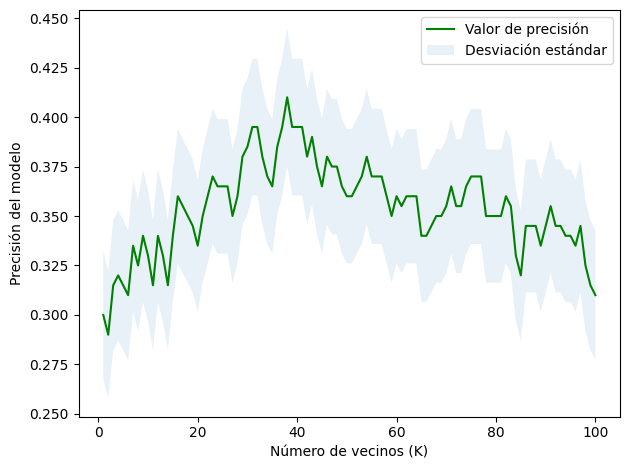

In [20]:
# Dibuja una línea verde que representa la precisión del modelo para cada valor de K (número de vecinos)
plt.plot(range(1, Ks+1), acc, 'g')

# Rellena el área entre la precisión menos una desviación estándar y la precisión más una desviación estándar
# Esto muestra la variabilidad de la precisión del modelo para cada valor de K
plt.fill_between(range(1, Ks+1), acc - 1 * std_acc, acc + 1 * std_acc, alpha=0.10)

# Añade una leyenda al gráfico para identificar las curvas
plt.legend(('Valor de precisión', 'Desviación estándar'))


# Etiqueta del eje Y
plt.ylabel('Precisión del modelo')

# Etiqueta del eje X
plt.xlabel('Número de vecinos (K)')


# Ajusta automáticamente el diseño del gráfico para que no se superpongan los elementos
plt.tight_layout()

# Muestra el gráfico
plt.show()

In [21]:
# Imprime en pantalla la mejor precisión obtenida (valor máximo en el array 'acc')
# y el valor de k correspondiente (índice del máximo + 1, ya que los índices empiezan en 0)

print( "The best accuracy was with", acc.max(), "with k =", acc.argmax()+1)

The best accuracy was with 0.41 with k = 38


Sin embargo, dado que esta gráfica sigue en ascenso, existe la posibilidad de que el modelo tenga un mejor rendimiento con un valor de k aún mayor."

### Probemos con k= 30

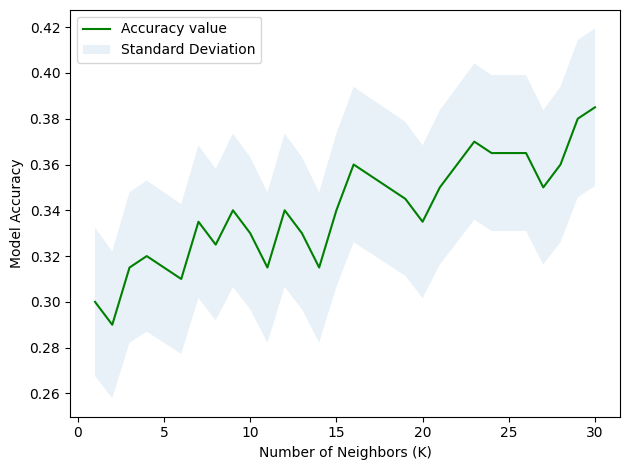

In [17]:

# Define el número máximo de vecinos (K) que se va a evaluar
Ks = 30

# Inicializa dos arrays de ceros para almacenar la precisión y la desviación estándar de cada modelo
acc = np.zeros((Ks))        # Precisión del modelo para cada valor de K
std_acc = np.zeros((Ks))    # Desviación estándar de la precisión para cada valor de K

# Bucle para entrenar y evaluar el modelo con diferentes valores de K
for n in range(1, Ks+1):
    # Entrena el modelo KNN con n vecinos usando los datos de entrenamiento
    knn_model_n = KNeighborsClassifier(n_neighbors=n).fit(X_train, y_train)

    # Realiza predicciones sobre los datos de prueba
    yhat = knn_model_n.predict(X_test)

    # Calcula la precisión del modelo y la guarda en el array acc
    acc[n-1] = accuracy_score(y_test, yhat)

    # Calcula la desviación estándar de la precisión y la guarda en std_acc
    # Esto mide la variabilidad en la predicción correcta
    std_acc[n-1] = np.std(yhat == y_test) / np.sqrt(yhat.shape[0])

# Representa gráficamente la precisión del modelo para cada valor de K
plt.plot(range(1, Ks+1), acc, 'g')  # Línea verde para la precisión

# Rellena el área alrededor de la línea de precisión con la desviación estándar
# Esto ayuda a visualizar la incertidumbre en la precisión
plt.fill_between(range(1, Ks+1), acc - 1 * std_acc, acc + 1 * std_acc, alpha=0.10)

# Añade una leyenda para identificar las curvas
plt.legend(('Valor de precisión', 'Desviación estándar'))

# Etiquetas de los ejes
plt.ylabel('Precisión del modelo')
plt.xlabel('Número de vecinos (K)')

# Ajusta el diseño del gráfico para evitar solapamientos
plt.tight_layout()

# Muestra el gráfico
plt.show()

### Probemos con k=100

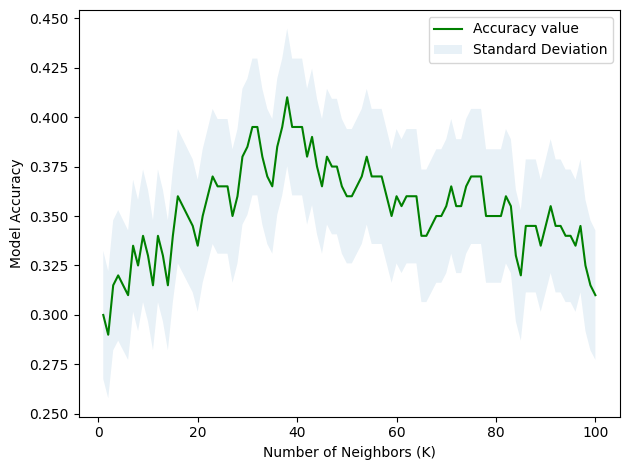

In [18]:

# Define el número máximo de vecinos (K) que se va a evaluar
Ks = 100

# Inicializa dos arrays de ceros para almacenar la precisión y la desviación estándar de cada modelo
acc = np.zeros((Ks))        # Precisión del modelo para cada valor de K
std_acc = np.zeros((Ks))    # Desviación estándar de la precisión para cada valor de K

# Bucle para entrenar y evaluar el modelo con diferentes valores de K
for n in range(1, Ks+1):
    # Entrena el modelo KNN con n vecinos usando los datos de entrenamiento
    knn_model_n = KNeighborsClassifier(n_neighbors=n).fit(X_train, y_train)

    # Realiza predicciones sobre los datos de prueba
    yhat = knn_model_n.predict(X_test)

    # Calcula la precisión del modelo y la guarda en el array acc
    acc[n-1] = accuracy_score(y_test, yhat)

    # Calcula la desviación estándar de la precisión y la guarda en std_acc
    # Esto mide la variabilidad en la predicción correcta
    std_acc[n-1] = np.std(yhat == y_test) / np.sqrt(yhat.shape[0])


# Representa gráficamente la precisión del modelo para cada valor de K
plt.plot(range(1, Ks+1), acc, 'g')  # Línea verde para la precisión

# Rellena el área alrededor de la línea de precisión con la desviación estándar
# Esto ayuda a visualizar la incertidumbre en la precisión
plt.fill_between(range(1, Ks+1), acc - 1 * std_acc, acc + 1 * std_acc, alpha=0.10)

# Añade una leyenda para identificar las curvas
plt.legend(('Valor de precisión', 'Desviación estándar'))

# Etiquetas de los ejes
plt.ylabel('Precisión del modelo')
plt.xlabel('Número de vecinos (K)')

# Ajusta el diseño del gráfico para evitar solapamientos
plt.tight_layout()

# Muestra el gráfico
plt.show()


### ¿Por qué llega un punto en el que se deteriora con el incremento de k?

Cuando k es pequeño (por ejemplo, k = 1), el modelo es muy sensible a los puntos individuales del conjunto de datos. La predicción para cada punto se basa en su vecino más cercano, lo que puede generar fronteras de decisión muy específicas y flexibles. Esto conduce a un sobreajuste del modelo sobre los datos de entrenamiento, lo que significa que el modelo puede tener un rendimiento excelente en el conjunto de entrenamiento, alcanzando incluso una precisión del 100%. Sin embargo, puede generalizar mal a datos no vistos.

Cuando k es grande, el modelo empieza a tener en cuenta más vecinos al hacer predicciones. Esto tiene dos consecuencias principales:

* Suavizado de la frontera de decisión: La frontera de decisión se vuelve más suave, lo que significa que el modelo es menos sensible al ruido o a las fluctuaciones en los datos de entrenamiento.
* Predicciones menos específicas: Con un k más grande, el modelo considera más vecinos y, por lo tanto, realiza predicciones más generalizadas, lo que puede hacer que se clasifiquen menos instancias de forma perfecta. Como resultado, el modelo se vuelve menos flexible y su capacidad para memorizar los datos de entrenamiento (lo que puede llevar a una precisión perfecta con k pequeño) se reduce.

### Incluso con el valor óptimo de k, el KNN no lo hace muy muy bien. ¿Por qué puede suceder esto?

El bajo rendimiento del modelo puede deberse a múltiples razones:

* El modelo KNN depende completamente del espacio de características original en el momento de la inferencia.
    * Si las características no proporcionan fronteras claras entre clases, KNN no puede mejorar esta separación. Es decir, si los datos están mezclados, KNN no puede clasificar correctamente.
    * El modelo KNN no puede mejorar las fronteras de decisión mediante optimización o transformación de características.

* Espacios de alta dimensión: Cuando hay muchas características débilmente correlacionadas, el número de dimensiones aumenta. Esto implica que:
    * la distancia entre los puntos tiende a volverse más uniforme, todos los puntos parecen estar igual de lejos unos de otros
    * Esto reduce el poder discriminativo del modelo KNN, los vecinos cercanos ya no son tan representativos.

* Tratamiento igualitario de todas las características: El algoritmo trata todas las características por igual al calcular las distancias. Por lo tanto:
    * Si algunas características aportan poco o nada (características débilmente correlacionadas), pueden introducir ruido.
    * Este ruido puede hacer que el modelo elija vecinos no representativos, afectando a la precisión.